## Step 1: Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import csv
import json
import random
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard, EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose

/mnt/d/Research/FL/OfficialProject/Codebase/.venv39/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-11-24 12:21:37.336559: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 12:21:37.458262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 12:21:37.489031: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been regist

## Step 2: Define parameters

In [ ]:
# Dataset
DATASET = "traffic"
# Number of data sheets to be loaded
NUM_DATA_SHEETS = 10
# Number of models in the federated learning setup
NUM_CLIENTS = 30
NUM_CLIENTS_TEST = 6
NUM_CLIENTS = NUM_CLIENTS_TEST
# Number of previous time points used for forecasting the next point
LOOK_BACK = 7
# Number of epochs for training
EPOCHS = 60
# Number of client epochs
CLIENT_EPOCHS = 10
# Number of batch size
BATCH_SIZE = 64
# Interval at which to save weights
SAVE_INTERVAL = 1
# Initial learning rate
LEARNING_RATE = 0.01
# Train-test size
TRAIN_SIZE = 0.7
# Data dir
DATA_DIR = "data"
# Client update matrix dir
CLIENT_MATRIX_DIR = "client_matrix"
# FL output dir
FL_OUTPUT_DIR = "federated_output"
# General output dir
GENERAL_OUTPUT_DIR = "summary_output"
# Prefix
PREFIX = "weighed"
# Missing rules
PERCENTAGE_MISSING_CLIENT = "01"
MISSING_MODE = "noadjacency"
MATRIX_MISSING_LENGTH = "10x10"
# Weight tracking directory
WEIGHT_TRACKING_DIR = f'weights_tracking_models/{DATASET}/{PREFIX}/{MATRIX_MISSING_LENGTH}/{MISSING_MODE}/{PERCENTAGE_MISSING_CLIENT}'

## Step 3: Set tf random seed

In [ ]:
tf.random.set_seed(3)  # Set random seed for reproducibility

## Step 4: Define functions

In [ ]:
def create_client_matrix(filename, rows=160, columns=100, missing_client_percentage=0.1, no_adjacent_missing=True):
    # Initialize the previous row as empty to enforce the no-adjacency rule
    prev_row = [''] * columns
    
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        for row_idx in range(rows):
            row = ['Y'] * columns
            if row_idx >= 2:
                N_count = int(columns * missing_client_percentage)
                
                # Ensure that 'N' is placed in positions not occupied by 'N' in the previous row
                if no_adjacent_missing:
                    possible_positions = [i for i in range(columns) if prev_row[i] != 'N']
                    N_positions = random.sample(possible_positions, min(N_count, len(possible_positions)))
                else:
                    N_positions = random.sample(range(columns), N_count)
                
                for pos in N_positions:
                    row[pos] = 'N'
            
            # Write the current row to the CSV file
            writer.writerow(row)
            
            # Update prev_row for the next iteration
            prev_row = row
            
# Function to load all sheets from an Excel file into a dictionary with error handling
def load_data(file_path, sheets):
    data_dict = {}
    for key, sheet in sheets.items():
        try:
            data_dict[key] = pd.read_excel(file_path, sheet_name=sheet)
            print(f"Loaded data for {key} from sheet {sheet}")
        except Exception as e:
            print(f"Failed to load data for {key} from sheet {sheet}: {e}")
    return data_dict

# Function to visualize data
def visualize_data(df, title, xlabel, ylabel):
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set(rc={"figure.figsize": (15, 6)})
    sns.histplot(df["Daily Value"], bins=50, kde=True, color="blue")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Function to create and compile the model
def create_model(input_shape, output_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dense(16, activation="sigmoid"))
    model.add(Dense(output_shape))
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mse", "mae", "mape"]
    )
    return model

# Function to plot data
def plot_the_data(orig_plot, predict_train_plot, predict_test_plot, title):
    plt.figure(figsize=(15, 6))
    plt.plot(orig_plot, color="blue", label="Actual")
    plt.plot(predict_train_plot, color="red", label="Predicted on training")
    plt.plot(predict_test_plot, color="green", label="Predicted on testing")
    plt.legend()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Sum of Values")
    plt.show()

# Data preparation functions
def scale_split_datasets(data, train_size, lookback):
    sc_X = StandardScaler()
    daily_consumption_scaled = sc_X.fit_transform(data.values.reshape(-1, 1))
    num_train = int(train_size * len(data))
    training_data = daily_consumption_scaled[:num_train]
    test_data = daily_consumption_scaled[num_train - lookback :]
    return training_data, test_data, sc_X

def create_rnn_dataset(data, lookback):
    data_x, data_y = [], []
    for i in range(len(data) - lookback - 1):
        a = data[i : (i + lookback), 0]
        data_x.append(a)
        data_y.append(data[i + lookback, 0])
    x = np.array(data_x)
    y = np.array(data_y)
    x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
    return x, y

def plot_data_preparation(data, predict_on_train, predict_on_test, lookback):
    total_size = len(predict_on_train) + len(predict_on_test)
    orig_data = data.to_numpy().reshape(len(data), 1)
    orig_plot = np.empty((total_size, 1))
    orig_plot[:, :] = np.nan
    orig_plot[:total_size, :] = orig_data[lookback:-2]
    predict_train_plot = np.empty((total_size, 1))
    predict_train_plot[:, :] = np.nan
    predict_train_plot[: len(predict_on_train), :] = predict_on_train
    predict_test_plot = np.empty((total_size, 1))
    predict_test_plot[:, :] = np.nan
    predict_test_plot[len(predict_on_train) : total_size, :] = predict_on_test
    return orig_plot, predict_train_plot, predict_test_plot

# Federated Learning Model Preparation
def create_train_test_dataset(df, lookback):
    df["Daily Value"] = df.iloc[:, 1:-1].sum(axis=1)
    sc_X = StandardScaler()
    daily_consumption = df["Daily Value"]
    num_train = int(TRAIN_SIZE * len(daily_consumption))
    daily_consumption_scaled = sc_X.fit_transform(
        daily_consumption.values.reshape(-1, 1)
    )
    training_set = daily_consumption_scaled[:num_train]
    x_train, y_train = create_rnn_dataset(training_set, lookback)
    test_data = daily_consumption_scaled[num_train - lookback :]
    x_test, y_test = create_rnn_dataset(test_data, lookback)
    return x_train, y_train, x_test, y_test, sc_X

def train_model(model, x_train, y_train, log_dir):
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    early_stopping = EarlyStopping(
        monitor="loss", min_delta=0.001, patience=5, verbose=1, mode="auto"
    )
    model.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        # callbacks=[tensorboard_callback, early_stopping],
        callbacks=[tensorboard_callback],
    )

# Evaluate the models
def evaluate_model(model, x_train, y_train, x_test, y_test):
    model.evaluate(x_train, y_train)
    model.evaluate(x_test, y_test)

# Federated learning aggregation sections
def federated_averaging(models, x_train, y_train, rounds=10):
    history_dict = {}
    for r in range(rounds):
        print(f"Round {r}:")
        history_dict[str(r)] = {}
        weights = [model.get_weights() for model in models]
        new_weights = [
            np.mean([w[i] for w in weights], axis=0) for i in range(len(weights[0]))
        ]
        for i in range(len(models)):
            models[i].set_weights(new_weights)
            history = models[i].fit(x_train, y_train, epochs=CLIENT_EPOCHS, batch_size=BATCH_SIZE, verbose=1)
            history_dict[str(r)][str(i)] = history.history

    return history_dict

def save_weights_to_csv(model, filename):
    """Save the model weights to a CSV file."""
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        for layer in model.weights:
            writer.writerow(layer.numpy().flatten())

def load_weights_from_csv(filename, model):
    """Load weights from a CSV file and set them to the model."""
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        new_weights = []
        for layer, row in zip(model.weights, reader):
            reshaped_weights = np.array(row, dtype=np.float32).reshape(layer.shape)
            new_weights.append(reshaped_weights)
        model.set_weights(new_weights)

def sum_weights_from_two_csvs(file1, file2, model):
    """Sum weights from two CSV files and set them to the model."""
    weights1 = []
    weights2 = []

    # Read weights from the first file
    with open(file1, 'r') as f1:
        reader1 = csv.reader(f1)
        weights1 = [np.array(row, dtype=np.float32) for row in reader1]

    # Read weights from the second file
    with open(file2, 'r') as f2:
        reader2 = csv.reader(f2)
        weights2 = [np.array(row, dtype=np.float32) for row in reader2]

    # Compute the sum of weights
    summed_weights = [0.2*w1 + 0.8*w2 for w1, w2 in zip(weights1, weights2)]

    # Reshape summed weights and set them to the model
    reshaped_weights = [
        weight.reshape(layer.shape) for weight, layer in zip(summed_weights, model.weights)
    ]
    model.set_weights(reshaped_weights)

def federated_weighing(models, x_train, y_train, client_matrix, round=10, has_weights_mechanism=False):
    history_dict = {}    
    for r in range(round):
        print(f"Round {r}:")
        history_dict[str(r)] = {}
        weights = [] #[model.get_weights() for model in models]
        for i in range(len(models)):
            if r >= 2 and client_matrix[r, i] == 'N':
                if has_weights_mechanism:
                    prev_csv_1 = f'{WEIGHT_TRACKING_DIR}/weights_tracking_model_client_{str(i)}_round_{str(r - 2)}.csv'
                    prev_csv_2 = f'{WEIGHT_TRACKING_DIR}/weights_tracking_model_client_{str(i)}_round_{str(r - 1)}.csv'
                    sum_weights_from_two_csvs(prev_csv_1, prev_csv_2, models[i])
                    print(f"Updated weights using the sum of round {r - 1} and {r - 2}")
                else:
                    zero_w = [0.0*np.random.rand(*w.shape) for w in models[i].get_weights()]
                    models[i].set_weights(zero_w)
            
            weights.append(models[i].get_weights())
        
        new_weights = [
            np.mean([w[i] for w in weights], axis=0) for i in range(len(weights[0]))
        ]
        for i in range(len(models)):
            models[i].set_weights(new_weights)
            history = models[i].fit(x_train, y_train, epochs=CLIENT_EPOCHS, batch_size=BATCH_SIZE, verbose=1)
            history_dict[str(r)][str(i)] = history.history
            # Save weights
            csv_file = f'{WEIGHT_TRACKING_DIR}/weights_tracking_model_client_{str(i)}_round_{str(r)}.csv'
            save_weights_to_csv(models[i], csv_file)
            print(f"Saved weights to {csv_file}")
    
    return history_dict

# Save results to json file
def to_json(filepath, history_dict):
    with open(filepath, "w") as f:
        json.dump(history_dict, f)

# Predictions and plotting
def inverse_transform_predictions(predictions, scaler):
    return scaler.inverse_transform(predictions)

# Plot predictions
def prepare_and_plot(data, train_predictions, test_predictions, lookback, title):
    orig_plot, train_plot, test_plot = plot_data_preparation(
        data, train_predictions, test_predictions, lookback
    )
    plot_the_data(orig_plot, train_plot, test_plot, title)

## Step 5.1: Load dataset

In [ ]:
# Define the file path and sheet names with their corresponding keys
file_path = f"{DATA_DIR}/{DATASET}/standard_{DATASET}.xlsx"
sheets = {}
for i in range(NUM_DATA_SHEETS):
    sheets[f'client_{str(i)}'] = f'Sheet_{str(i + 2)}'

# Load the data
dictionary = load_data(file_path, sheets)

Loaded data for client_0 from sheet Sheet_2
Loaded data for client_1 from sheet Sheet_3
Loaded data for client_2 from sheet Sheet_4
Loaded data for client_3 from sheet Sheet_5
Loaded data for client_4 from sheet Sheet_6
Loaded data for client_5 from sheet Sheet_7
Loaded data for client_6 from sheet Sheet_8
Loaded data for client_7 from sheet Sheet_9
Loaded data for client_8 from sheet Sheet_10
Loaded data for client_9 from sheet Sheet_11


## Step 5.2: Example for client_1 data

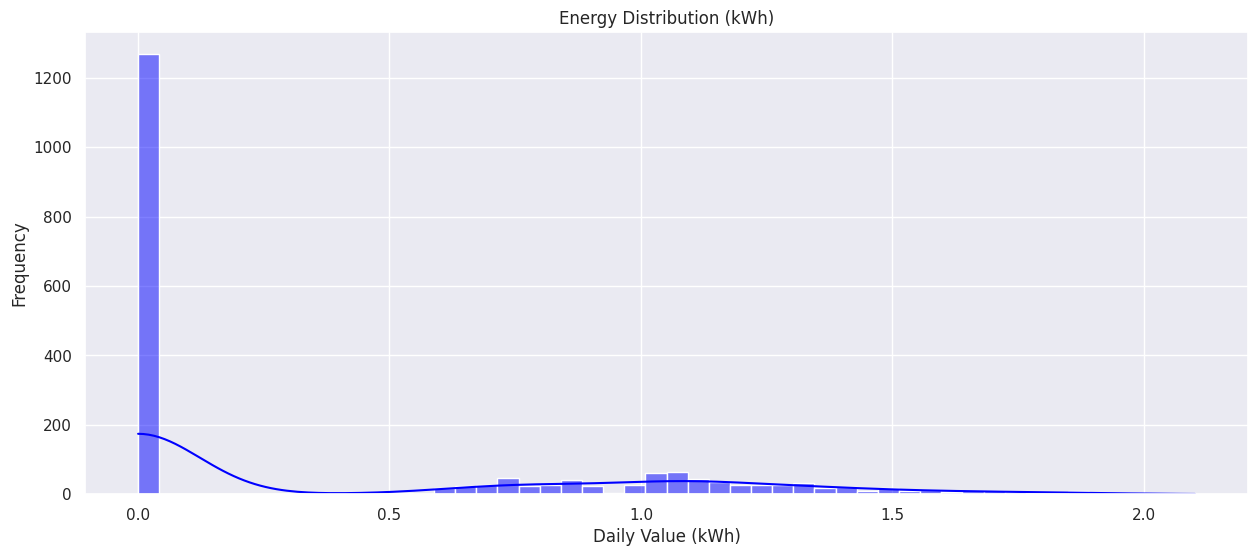

In [ ]:
client_name = "client_1"
df = dictionary[client_name]
df["Daily Value"] = df.iloc[:, 1:-1].sum(axis=1)

# Visualize data
visualize_data(df, "Energy Distribution (kWh)", "Daily Value (kWh)", "Frequency")

## Step 5.3: Split train/test data

In [ ]:
# Scale and split data
training_set, test_data, sc_X = scale_split_datasets(
    df["Daily Value"], TRAIN_SIZE, LOOK_BACK
)
x_train, y_train = create_rnn_dataset(training_set, LOOK_BACK)
x_test, y_test = create_rnn_dataset(test_data, LOOK_BACK)

## Step 5.4: Create models

In [ ]:
# Create and train the model
ts_model = create_model(input_shape=(1, LOOK_BACK), output_shape=1)
log_dir = f"logs/{PREFIX}fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

ts_model.fit(
    x_train,
    y_train,
    epochs=CLIENT_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[tensorboard_callback],
)

# Evaluate model
ts_model.evaluate(x_test, y_test, verbose=1)
predict_on_train = ts_model.predict(x_train)
predict_on_test = ts_model.predict(x_test)

2024-11-23 04:13:24.451281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-23 04:13:24.515336: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/5
1391/1391 [==============================] - 4s 2ms/step - loss: 0.1317 - mse: 0.1317 - mae: 0.2089 - mape: 22.6042
Epoch 2/5
1391/1391 [==============================] - 2s 1ms/step - loss: 0.0851 - mse: 0.0851 - mae: 0.1569 - mape: 16.4600
Epoch 3/5
1391/1391 [==============================] - 2s 2ms/step - loss: 0.0828 - mse: 0.0828 - mae: 0.1536 - mape: 16.2282
Epoch 4/5
1391/1391 [==============================] - 2s 2ms/step - loss: 0.0837 - mse: 0.0837 - mae: 0.1557 - mape: 16.5307
Epoch 5/5
19/19 [==============================] - 0s 1ms/step


## Step 5.5: Try plotting

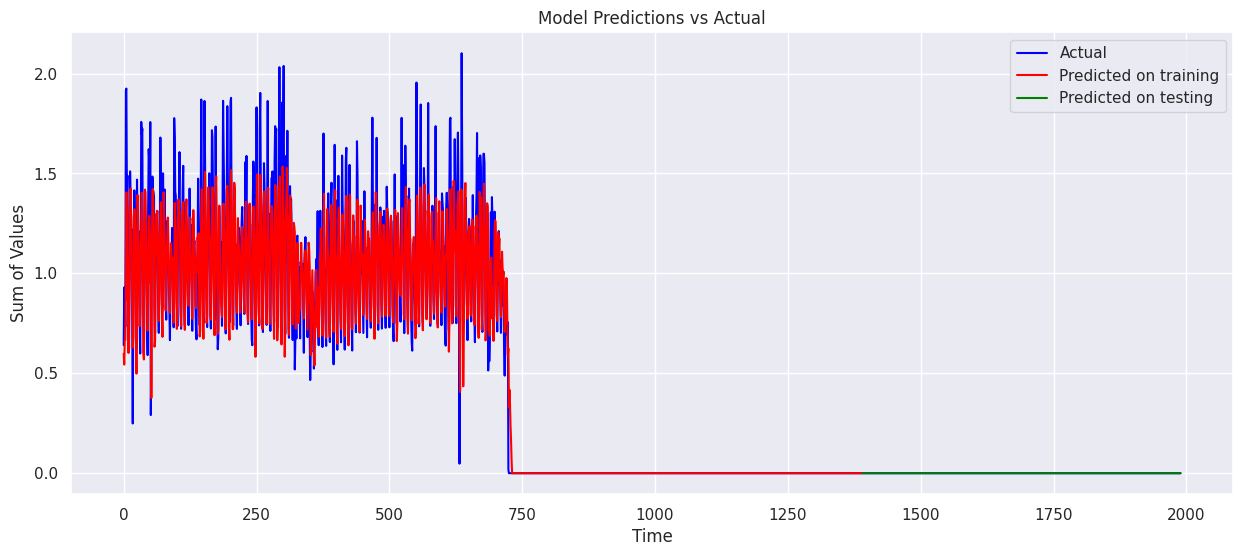

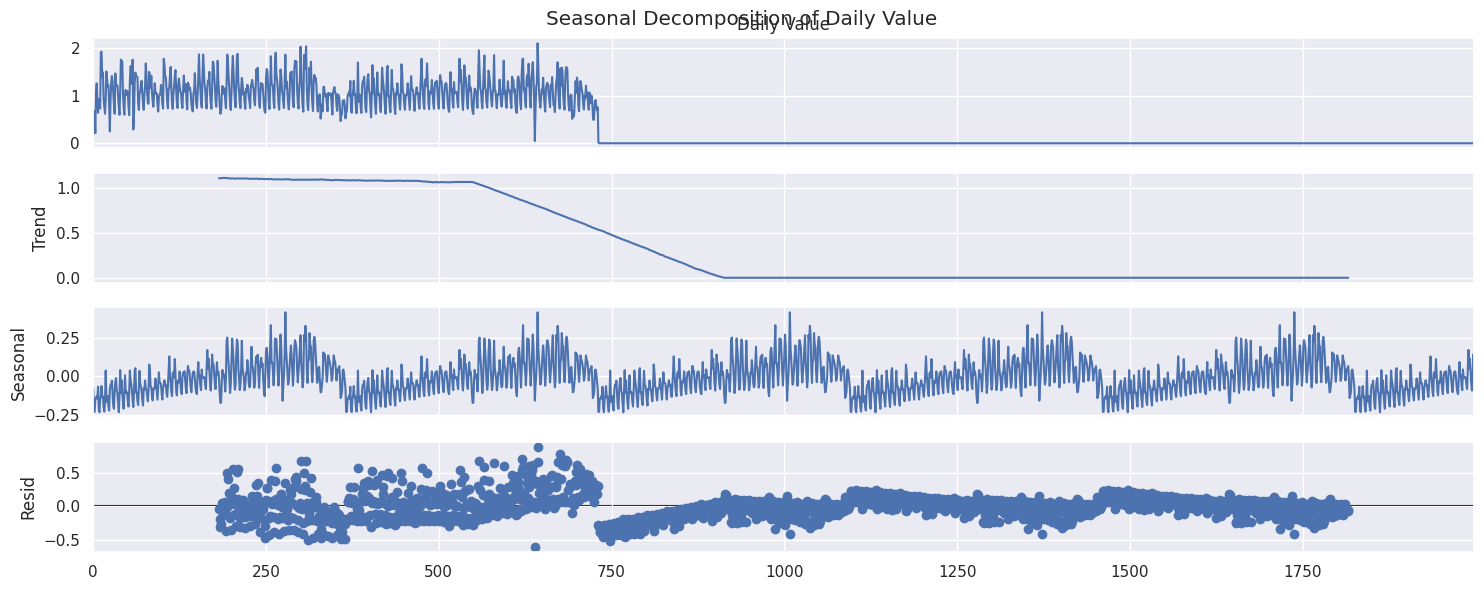

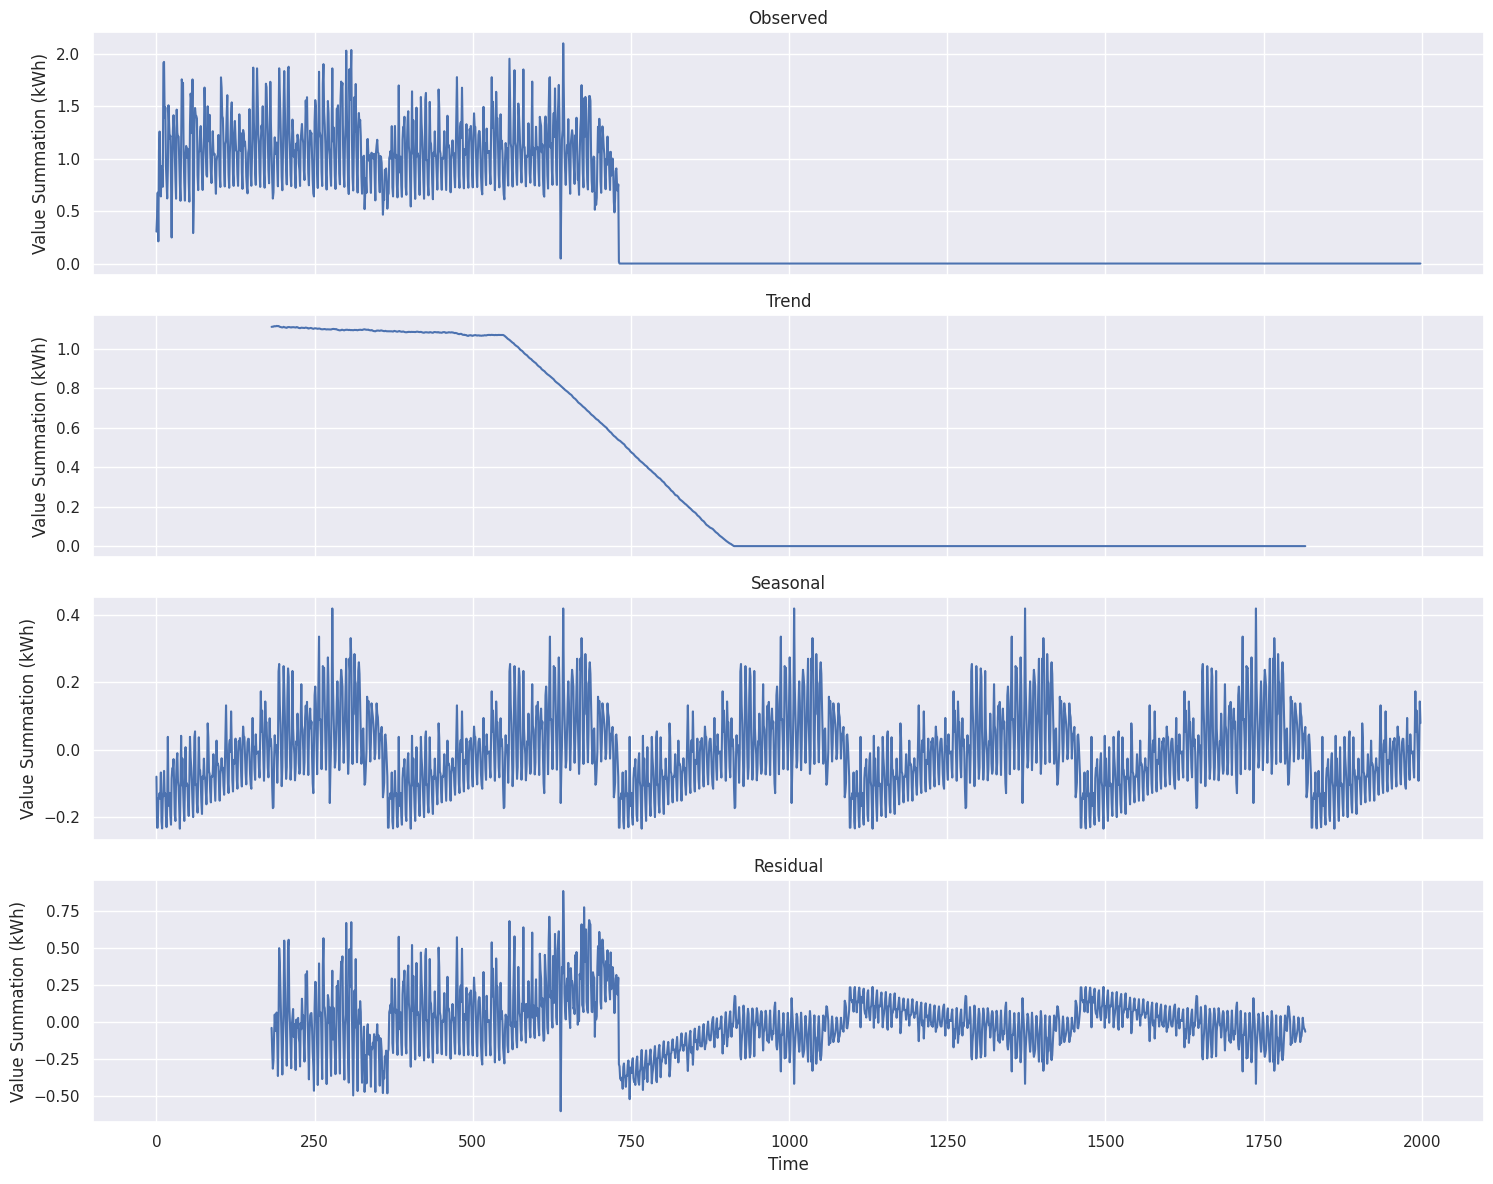

In [ ]:
predict_on_train = sc_X.inverse_transform(predict_on_train)
predict_on_test = sc_X.inverse_transform(predict_on_test)

# Plot predictions
plot_original, plot_train, plot_test = plot_data_preparation(
    df["Daily Value"], predict_on_train, predict_on_test, LOOK_BACK
)
plot_the_data(plot_original, plot_train, plot_test, "Model Predictions vs Actual")

# Seasonal decomposition
result = seasonal_decompose(df["Daily Value"], model="additive", period=365)
result.plot()
plt.suptitle("Seasonal Decomposition of Daily Value")
plt.show()

# Enhanced visualization of seasonal decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
result.observed.plot(ax=axes[0], title="Observed")
result.trend.plot(ax=axes[1], title="Trend")
result.seasonal.plot(ax=axes[2], title="Seasonal")
result.resid.plot(ax=axes[3], title="Residual")
for ax in axes:
    ax.set_ylabel("Value Summation (kWh)")
axes[3].set_xlabel("Time")
plt.tight_layout()
plt.show()

## Step 5.6: Try saving to excel file

In [ ]:
# Save the residuals to an Excel file
os.makedirs(f'{GENERAL_OUTPUT_DIR}/{client_name}', exist_ok=True)
pd.DataFrame(result.resid).to_excel(
    f"{GENERAL_OUTPUT_DIR}/{client_name}/{PREFIX}_client.xlsx", sheet_name="Decomposition_Residuals"
)

# Summary statistics
residual_stats = pd.DataFrame(
    {
        "Mean": [result.resid.mean()],
        "Median": [result.resid.median()],
        "Standard Deviation": [result.resid.std()],
        "Max": [result.resid.max()],
        "Min": [result.resid.min()],
    }
)

# Save summary statistics
residual_stats.to_excel(f"{GENERAL_OUTPUT_DIR}/{client_name}/{PREFIX}residual_statistics.xlsx", index=False)

# Display summary statistics
print("Summary Statistics of Residuals:")
print(residual_stats)

Summary Statistics of Residuals:
       Mean    Median  Standard Deviation       Max       Min
0 -0.006794 -0.010618            0.193273  0.882012 -0.605156


## Step 5.7: Evaluate models

In [ ]:
# Evaluation metrics
metrics = ts_model.evaluate(x_test, y_test, verbose=1)
metrics_df = pd.DataFrame([metrics], columns=["Loss", "MSE", "MAE", "MAPE"])

# Save evaluation metrics
metrics_df.to_excel(f"{GENERAL_OUTPUT_DIR}/{client_name}/{PREFIX}evaluation_metrics.xlsx", index=False)

# Display evaluation metrics
print("Evaluation Metrics:")
print(metrics_df)

19/19 [==============================] - 0s 2ms/step - loss: 4.4358e-07 - mse: 4.4358e-07 - mae: 6.6602e-04 - mape: 0.0934
Evaluation Metrics:
           Loss           MSE       MAE      MAPE
0  4.435809e-07  4.435809e-07  0.000666  0.093434


## Step 5.8: Create train/test set

In [ ]:
train_test_dataset = []
for i in range(NUM_DATA_SHEETS):
    _x_train, _y_train, _x_test, _y_test, _sc_cl = create_train_test_dataset(dictionary[f'client_{str(i)}'], LOOK_BACK)
    train_test_dataset.append((_x_train, _y_train, _x_test, _y_test, _sc_cl))

## Step 5.9: Create model arrays

In [ ]:
model_arr = []
for i in range(NUM_DATA_SHEETS):
    _model = create_model(input_shape=(1, LOOK_BACK), output_shape=1)
    model_arr.append(_model)

## Step 5.10: Train models

In [ ]:
for i in range(NUM_CLIENTS):
    _x_train, _y_train, _, _, _ = train_test_dataset[i]
    train_model(model_arr[i], _x_train, _y_train, f'logs/fit/{PREFIX}{str(i)}')

Epoch 1/60
503/503 [==============================] - 2s 2ms/step - loss: 0.5532 - mse: 0.5532 - mae: 0.5771 - mape: 809.0249
Epoch 2/60
503/503 [==============================] - 1s 2ms/step - loss: 0.3947 - mse: 0.3947 - mae: 0.4424 - mape: 955.5471
Epoch 3/60
503/503 [==============================] - 1s 2ms/step - loss: 0.3847 - mse: 0.3847 - mae: 0.4445 - mape: 802.0899
Epoch 4/60
503/503 [==============================] - 1s 2ms/step - loss: 0.3844 - mse: 0.3844 - mae: 0.4443 - mape: 1021.8129
Epoch 5/60
503/503 [==============================] - 1s 2ms/step - loss: 0.3779 - mse: 0.3779 - mae: 0.4347 - mape: 882.6664
Epoch 6/60
503/503 [==============================] - 1s 2ms/step - loss: 0.3783 - mse: 0.3783 - mae: 0.4380 - mape: 1100.0469
Epoch 7/60
503/503 [==============================] - 1s 2ms/step - loss: 0.3751 - mse: 0.3751 - mae: 0.4325 - mape: 1252.8054
Epoch 8/60
503/503 [==============================] - 1s 2ms/step - loss: 0.3683 - mse: 0.3683 - mae: 0.4246 - mape

## Step 5.11: Evaluate models

In [ ]:
for i in range(NUM_CLIENTS):
    _x_train, _y_train, _x_test, _y_test, _ = train_test_dataset[i]
    evaluate_model(model_arr[i], _x_train, _y_train, _x_test, _y_test)

19/19 [==============================] - 0s 1ms/step - loss: 2.3965e-05 - mse: 2.3965e-05 - mae: 0.0049 - mape: 0.6994


## Step 6: Execute the proposed method

In [ ]:
# create_client_matrix(f'{CLIENT_MATRIX_DIR}/client_matrix.csv', missing_client_percentage=0.1, no_adjacent_missing=True)
client_matrix = np.loadtxt(f'{CLIENT_MATRIX_DIR}/client_matrix_{MATRIX_MISSING_LENGTH}_{PERCENTAGE_MISSING_CLIENT}_{MISSING_MODE}.csv', delimiter=',', dtype=str)
if not os.path.exists(WEIGHT_TRACKING_DIR):
    os.makedirs(WEIGHT_TRACKING_DIR)

history_client_weight_dict = {}
for i in range(len(model_arr)):
    _x_train, _y_train, _, _, _ = train_test_dataset[i]
    print(f"Processing turn {i}...")
    hist_dict_weight = federated_weighing(model_arr, _x_train, _y_train, client_matrix, has_weights_mechanism=True)
    history_client_weight_dict[f'client_{str(i)}'] = hist_dict_weight

Processing turn 0...
Round 0:
Epoch 1/60
503/503 [==============================] - 1s 1ms/step - loss: 0.6550 - mse: 0.6550 - mae: 0.6560 - mape: 578.3527
Epoch 2/60
503/503 [==============================] - 1s 1ms/step - loss: 0.4025 - mse: 0.4025 - mae: 0.4404 - mape: 922.3887
Epoch 3/60
503/503 [==============================] - 1s 1ms/step - loss: 0.3855 - mse: 0.3855 - mae: 0.4331 - mape: 864.5974
Epoch 4/60
503/503 [==============================] - 1s 1ms/step - loss: 0.3826 - mse: 0.3826 - mae: 0.4326 - mape: 934.8422
Epoch 5/60
503/503 [==============================] - 1s 1ms/step - loss: 0.3769 - mse: 0.3769 - mae: 0.4296 - mape: 889.1178
Epoch 6/60
503/503 [==============================] - 1s 1ms/step - loss: 0.3765 - mse: 0.3765 - mae: 0.4285 - mape: 1027.7377
Epoch 7/60
503/503 [==============================] - 1s 1ms/step - loss: 0.3731 - mse: 0.3731 - mae: 0.4265 - mape: 1130.8743
Epoch 8/60
503/503 [==============================] - 1s 1ms/step - loss: 0.3669 - mse

In [ ]:
history_client_save_dir = f"model_history/{DATASET}/{PREFIX}/clients/{MATRIX_MISSING_LENGTH}/{PERCENTAGE_MISSING_CLIENT}/{MISSING_MODE}"
if not os.path.exists(history_client_save_dir):
    os.makedirs(history_client_save_dir)

to_json(f"{history_client_save_dir}/losses_rmses.json", history_client_weight_dict)

In [ ]:
# Get loss of central model after training all round with all clients
weigh_central_x_train, weigh_central_y_train, weigh_central_x_test, weight_central_y_test, _ = train_test_dataset[0]
weigh_central_model = create_model(input_shape=(1, LOOK_BACK), output_shape=1)
weights = [model.get_weights() for model in model_arr]
new_weights = [
            np.mean([w[i] for w in weights], axis=0) for i in range(len(weights[0]))
        ]
weigh_central_model.set_weights(new_weights)
central_history = weigh_central_model.fit(weigh_central_x_train, weigh_central_y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

losses = central_history.history['loss']
rmses = [x**(1/2) for x in central_history.history['mse']]

losses_rmses_dict = {
    "losses": losses,
    "rmses": rmses
}

In [ ]:
from sklearn.metrics import mean_squared_error
weight_central_predictions = weigh_central_model.predict(weigh_central_x_test)
print("Central model prediction/test RMSE: {}".format((mean_squared_error(weight_central_y_test, weight_central_predictions)**(1/2))))

In [ ]:
history_central_save_dir = f"model_history/{DATASET}/{PREFIX}/central/{MATRIX_MISSING_LENGTH}/{PERCENTAGE_MISSING_CLIENT}/{MISSING_MODE}"
if not os.path.exists(history_central_save_dir):
    os.makedirs(history_central_save_dir)

to_json(f"{history_central_save_dir}/losses_rmses.json", losses_rmses_dict)

In [ ]:
# Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, label=f'Central Model Training RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Training Loss for Central Model')
plt.show()

# RMSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rmses) + 1), rmses, label=f'Central Model Training RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title(f'Training Loss for Central Model')
plt.show()

In [ ]:
train_predictions_arr = []
for i in range(NUM_CLIENTS):
    _x_train, _y_train, _x_test, _y_test, _sc_cl = train_test_dataset[i]
    _train_predictions = inverse_transform_predictions(model_arr[i].predict(_x_train), _sc_cl)
    train_predictions_arr.append(_train_predictions)

In [ ]:
test_predictions_arr = []
for i in range(NUM_CLIENTS):
    _x_train, _y_train, _x_test, _y_test, _sc_cl = train_test_dataset[i]
    _test_predictions = inverse_transform_predictions(model_arr[i].predict(_x_test), _sc_cl)
    test_predictions_arr.append(_test_predictions)

In [ ]:
for i in range(NUM_CLIENTS):
    prepare_and_plot(
        dictionary[f'client_{i}']['Daily Value'],
        train_predictions_arr[i],
        test_predictions_arr[i],
        LOOK_BACK,
        f"FL Model - Client {i}"
    )

In [ ]:
# Save the predictions
output_dir = f"{FL_OUTPUT_DIR}/{PREFIX}federated"
os.makedirs(output_dir, exist_ok=True)

predictions_files = {}
for i in range(NUM_CLIENTS):
    predictions_files[f'client{i}_test_predictions'] = test_predictions_arr[i]
    predictions_files[f'client{i}_train_predictions'] = train_predictions_arr[i]
    predictions_files[f'client{i}_original'] = dictionary[f'client_{i}']['Daily Value']

for filename, data in predictions_files.items():
    pd.DataFrame(data).to_excel(f"{output_dir}/{PREFIX}{filename}.xlsx")